In [164]:
import pandas as pd
import sns
import train
import holidays

df = pd.read_csv('cleaneddata.csv')
# df

/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_83264/3313321410.py:5: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaneddata.csv')


In [165]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt

In [166]:
de_holidays = holidays.Germany(prov='NW')

In [167]:
pd.set_option('display.max_columns', None)

print(df.head())

           DateOfOrder   OrderId                     TransactionId  \
0  2019-12-02 20:39:46  11161800  5fff5813ae674809a06e3b1fe5528fcf   
1  2019-12-02 20:39:46  11161801  7c4f0e97356e46669abefe8dc5fb0ff0   
2  2019-12-03 22:29:24  11166739  ee1d1a4a7458414a8bb420111ba0fa8c   
3  2019-12-04 13:27:22  11169532  86497dc4e7434b838a335c439325fb65   
4  2019-12-04 13:27:22  11169533  6054345ad0b14bd297dbdc6372ff1488   

  DateOfService  OrderQty          MenuName  MenuPrice  MenuSubsidy  \
0    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
1    2020-01-03         1  Mittagessen (BS)       3.05          0.0   
2    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
3    2020-01-02         1  Mittagessen (BS)       3.05          0.0   
4    2020-01-03         1  Mittagessen (BS)       3.05          0.0   

       BookingNr       GroupName  CanceledQty DateOfCancel Site SchoolID  \
0  474-136052114  Bad Sassendorf            0          NaN   LP   SCH003   


In [168]:
df

,DateOfOrder,OrderId,TransactionId,DateOfService,OrderQty,MenuName,MenuPrice,MenuSubsidy,BookingNr,GroupName,CanceledQty,DateOfCancel,Site,SchoolID,net_qty,days_to_cancel,MenuNorm,MenuBase,MenuCode,day_of_year,weekday,is_weekend,sin_doy,cos_doy,cancel_timing,subsidy_pct,month,quarter,day_of_month,is_month_end,is_month_start,order_hour,morning,afternoon,evening,hist_cancel_rate,is_holiday
0,2019-12-02 20:39:46,11161800,5fff5813ae674809a06e3b1fe5528fcf,2020-01-02,1,Mittagessen (BS),3.05,0.00,474-136052114,Bad Sassendorf,0,NaN,LP,SCH003,1,-1,MITTAGESSEN (BS),MITTAGESSEN,BS,336,1,0,-0.963471,-0.267814,NaN,0.0,12,4,2,0,0,20,0,0,1,1.049900,0
1,2019-12-02 20:39:46,11161801,7c4f0e97356e46669abefe8dc5fb0ff0,2020-01-03,1,Mittagessen (BS),3.05,0.00,474-136052114,Bad Sassendorf,0,NaN,LP,SCH003,1,-1,MITTAGESSEN (BS),MITTAGESSEN,BS,336,1,0,-0.963471,-0.267814,NaN,0.0,12,4,2,0,0,20,0,0,1,1.049900,0
2,2019-12-03 22:29:24,11166739,ee1d1a4a7458414a8bb420111ba0fa8c,2020-01-02,1,Mittagessen (BS),3.05,0.00,474-136060130,Bad Sassendorf,0,NaN,LP,SCH003,1,-1,MITTAGESSEN (BS),MITTAGESSEN,BS,337,2,0,-0.963471,-0.267814,NaN,0.0,12,4,3,0,0,22,0,0,1,1.049900,0
3,2019-12-04 13:27:22,11169532,86497dc4e7434b838a335c439325fb65,2020-01-02,1,Mittagessen (BS),3.05,0.00,474-136047096,Bad Sassendorf,0,NaN,LP,SCH003,1,-1,MITTAGESSEN (BS),MITTAGESSEN,BS,338,3,0,-0.963471,-0.267814,NaN,0.0,12,4,4,0,0,13,0,1,0,1.049900,0
4,2019-12-04 13:27:22,11169533,6054345ad0b14bd297dbdc6372ff1488,2020-01-03,1,Mittagessen (BS),3.05,0.00,474-136047096,Bad Sassendorf,0,NaN,LP,SCH003,1,-1,MITTAGESSEN (BS),MITTAGESSEN,BS,338,3,0,-0.963471,-0.267814,NaN,0.0,12,4,4,0,0,13,0,1,0,1.049900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5671161,2024-08-27 11:54:08,28525140,3afb68785a33434d8a5d33464e400d94_order,2023-12-14,1,Mittagessen (BK),0.00,4.15,900-170863713,Hamm ermäßigt,0,NaN,BK,SCH139,1,-1,MITTAGESSEN (BK),MITTAGESSEN,BK,240,2,0,-0.963471,-0.267814,NaN,inf,8,3,27,0,0,11,1,0,0,0.995023,0
5671162,2024-08-27 11:54:09,28525148,4ae5064b9fc24653becf25d6dca02cac_order,2023-12-15,1,Mittagessen (BK),0.00,4.15,900-170863713,Hamm ermäßigt,0,NaN,BK,SCH139,1,-1,MITTAGESSEN (BK),MITTAGESSEN,BK,240,2,0,-0.963471,-0.267814,NaN,inf,8,3,27,0,0,11,1,0,0,0.995023,0
5671163,2024-08-27 11:54:11,28525166,5a3c0717d64542ba95c10751b97be085_order,2023-12-18,1,Mittagessen (BK),0.00,4.15,900-170863713,Hamm ermäßigt,0,NaN,BK,SCH139,1,-1,MITTAGESSEN (BK),MITTAGESSEN,BK,240,2,0,-0.963471,-0.267814,NaN,inf,8,3,27,0,0,11,1,0,0,0.995023,0
5671164,2024-08-27 11:54:12,28525175,5132cd3f4237409a9e700a9ad8c47da2_order,2023-12-19,1,Mittagessen (BK),0.00,4.15,900-170863713,Hamm ermäßigt,0,NaN,BK,SCH139,1,-1,MITTAGESSEN (BK),MITTAGESSEN,BK,240,2,0,-0.963471,-0.267814,NaN,inf,8,3,27,0,0,11,1,0,0,0.995023,0


In [169]:
# checking if there is still cases remaing wich have Dateofservice before dateoforder

df['DateOfOrder'] = pd.to_datetime(df['DateOfOrder'])
df['DateOfService'] = pd.to_datetime(df['DateOfService'])

filtered_df = df[df['DateOfService'] < df['DateOfOrder'].dt.date]


In [170]:
# checking for missing sites
print(df['Site'].unique())


['LP' 'BK' nan 'MS']



--- Step 1: Cancellation Prediction Analysis ---
Goal: Understand the drivers of cancellations to improve our net demand forecast.
Training cancellation classifier...

Insight: Visualizing what drives cancellations...


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_83264/3871864580.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')


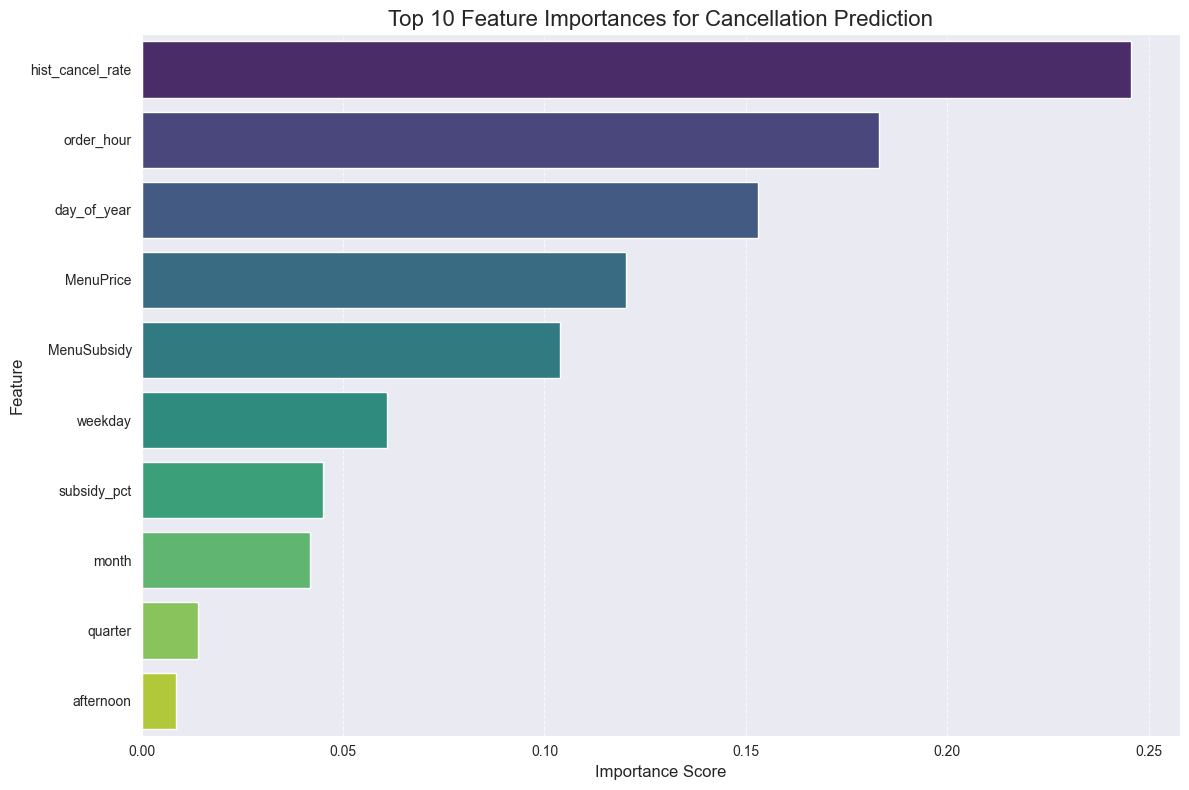


Insight: How well does our model distinguish between canceled and non-canceled orders?


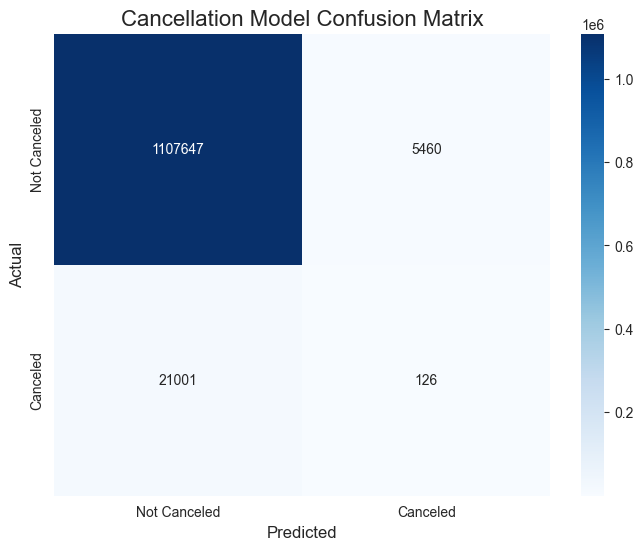


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113107
           1       0.02      0.01      0.01     21127

    accuracy                           0.98   1134234
   macro avg       0.50      0.50      0.50   1134234
weighted avg       0.96      0.98      0.97   1134234

Conclusion: The feature importance plot clearly shows that historical cancellation rates and subsidy percentages are key predictors. The confusion matrix gives us a clear picture of the model's accuracy, precision, and recall.

--- End of Step 1 ---
--------------------------------------------------


In [191]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# --- 1. CANCELLATION PREDICTION ANALYSIS ---
print("\n--- Step 1: Cancellation Prediction Analysis ---")
print("Goal: Understand the drivers of cancellations to improve our net demand forecast.")
df['is_canceled'] = (df['CanceledQty'] > 0).astype(int)

# Feature selection for cancellation model
cancel_features = [
    'MenuPrice', 'MenuSubsidy', 'subsidy_pct', 'day_of_year', 'weekday',
    'is_weekend', 'sin_doy', 'cos_doy', 'month', 'quarter', 'is_month_end',
    'is_month_start', 'order_hour', 'morning', 'afternoon', 'evening',
    'hist_cancel_rate', 'is_holiday'
]
target_cancel = 'is_canceled'

X_cancel = df[cancel_features].copy()
y_cancel = df[target_cancel]

# Handle potential missing values
X_cancel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_cancel = X_cancel.ffill().bfill()
for col in X_cancel.columns:
    if X_cancel[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X_cancel[col]):
            X_cancel[col] = X_cancel[col].fillna(0)
        else:
            X_cancel[col] = X_cancel[col].fillna(X_cancel[col].mode()[0])

# Time-based split for training and testing
split_index = int(len(df) * 0.8)
X_train_c, X_test_c = X_cancel[:split_index], X_cancel[split_index:]
y_train_c, y_test_c = y_cancel[:split_index], y_cancel[split_index:]

# Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
print("Training cancellation classifier...")
rf_classifier.fit(X_train_c, y_train_c)

# --- VISUALIZATION 1.1: CANCELLATION FEATURE IMPORTANCE ---
print("\nInsight: Visualizing what drives cancellations...")
feature_importances = pd.DataFrame({
    'feature': cancel_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importances for Cancellation Prediction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- VISUALIZATION 1.2: CONFUSION MATRIX ---
print("\nInsight: How well does our model distinguish between canceled and non-canceled orders?")
y_pred_c = rf_classifier.predict(X_test_c)
cm = confusion_matrix(y_test_c, y_pred_c)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'])
plt.title('Cancellation Model Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_c))
print("Conclusion: The feature importance plot clearly shows that historical cancellation rates and subsidy percentages are key predictors. The confusion matrix gives us a clear picture of the model's accuracy, precision, and recall.")
print("\n--- End of Step 1 ---")
print("-" * 50)


--- Step 2: Data Preparation for Forecasting ---
Goal: Aggregate data and create target variables for future meal counts.

Insight: Let's visualize the daily demand patterns for a few locations.


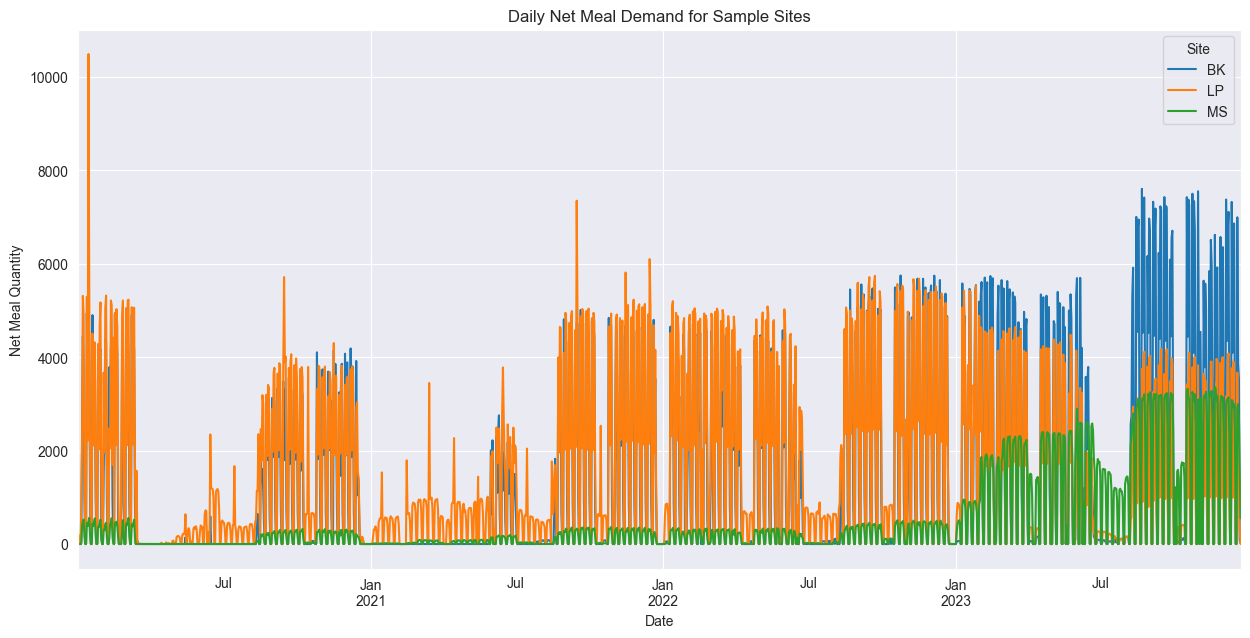


Creating target variables for different forecast horizons...
Target variables created.

--- End of Step 2 ---


In [192]:

# --- 2. DATA PREPARATION FOR FORECASTING ---
print("\n--- Step 2: Data Preparation for Forecasting ---")
print("Goal: Aggregate data and create target variables for future meal counts.")

# Aggregate data to Site-Day level
# We sum the 'net_qty' for each Site on each 'DateOfService'
daily_demand = df.groupby(['DateOfService', 'Site'], observed=False)['net_qty'].sum().reset_index()


# Pivot to have sites as columns, making it easier to process per site
pivot_demand = daily_demand.pivot(index='DateOfService', columns='Site', values='net_qty').fillna(0)

# Create a full date range to ensure no gaps
full_date_range = pd.date_range(start=pivot_demand.index.min(), end=pivot_demand.index.max(), freq='D')
pivot_demand = pivot_demand.reindex(full_date_range, fill_value=0)

# --- VISUALIZATION 2.1: DAILY DEMAND FOR SAMPLE SITES ---
print("\nInsight: Let's visualize the daily demand patterns for a few locations.")
sample_sites = pivot_demand.columns[:min(3, len(pivot_demand.columns))]
pivot_demand[sample_sites].plot(figsize=(15, 7), subplots=False, title='Daily Net Meal Demand for Sample Sites')
plt.ylabel('Net Meal Quantity')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Site')
plt.show()

pivot_demand
# Feature Engineering for the forecasting model
# We create time-based features on our complete daily index
time_features = pd.DataFrame(index=pivot_demand.index)
time_features['day_of_year'] = time_features.index.dayofyear
time_features['weekday'] = time_features.index.weekday
time_features['is_weekend'] = time_features.index.weekday >= 5
time_features['month'] = time_features.index.month
time_features['quarter'] = time_features.index.quarter
time_features['day_of_month'] = time_features.index.day
time_features['sin_doy'] = np.sin(2 * np.pi * time_features['day_of_year'] / 365.25)
time_features['cos_doy'] = np.cos(2 * np.pi * time_features['day_of_year'] / 365.25)
# Add holiday info if available for the date range
# For this example, we'll simulate it
# time_features['is_holiday'] = np.random.choice([0, 1], size=len(time_features), p=[0.97, 0.03])
# todois_canceled
time_features['is_holiday'] = time_features.index.to_series().apply(lambda x: int(x in de_holidays))


# Create lagged features and rolling means (important for time series)
for lag in [1, 2, 3, 7, 14]:
    time_features[f'lag_{lag}'] = pivot_demand.shift(lag).mean(axis=1) # Mean demand across all sites 'lag' days ago

time_features['rolling_mean_7'] = time_features['lag_1'].rolling(window=7).mean()
time_features['rolling_mean_14'] = time_features['lag_1'].rolling(window=14).mean()
time_features = time_features.fillna(0)


# Create Target Variables for each horizon
# To predict the future, the target 'y' must be shifted from the future to the current row.
print("\nCreating target variables for different forecast horizons...")

# Horizon 1: <= 1 day (predicting tomorrow's total for each site)
targets_1_day = pivot_demand.shift(-1)

# Horizon 2: 2-5 days (predicting the average demand for days t+2 to t+5 for each site)
targets_2_5_days = pivot_demand.rolling(window=4, min_periods=1).mean().shift(-5)

# Horizon 3: > 5 days (predicting the average demand for days t+6 to t+10 for each site)
targets_6_10_days = pivot_demand.rolling(window=5, min_periods=1).mean().shift(-10)
# ***  Define the target_dfs dictionary ***
target_dfs = {
    'target_1_day': targets_1_day,
    'target_2_5_days': targets_2_5_days,
    'target_6_10_days': targets_6_10_days,
}

print("Target variables created.")
print("\n--- End of Step 2 ---")


In [173]:
pivot_demand

Site,BK,LP,MS
2020-01-02,32.0,169.0,0.0
2020-01-03,32.0,184.0,0.0
2020-01-04,0.0,1.0,0.0
2020-01-05,0.0,0.0,0.0
2020-01-06,50.0,696.0,0.0
...,...,...,...
2023-12-18,6992.0,3669.0,2929.0
2023-12-19,3863.0,961.0,2993.0
2023-12-20,3544.0,1296.0,2689.0
2023-12-21,83.0,280.0,1640.0


In [174]:
time_features

,day_of_year,weekday,is_weekend,month,quarter,day_of_month,sin_doy,cos_doy,is_holiday,lag_1,lag_2,lag_3,lag_7,lag_14,rolling_mean_7,rolling_mean_14
2020-01-02,2,3,False,1,1,2,0.034398,0.999408,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,3,4,False,1,1,3,0.051584,0.998669,0,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,4,5,True,1,1,4,0.068755,0.997634,0,72.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,5,6,True,1,1,5,0.085906,0.996303,0,0.333333,72.000000,67.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,6,0,False,1,1,6,0.103031,0.994678,0,0.000000,0.333333,72.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-18,352,0,False,12,4,18,-0.225964,0.974136,0,0.000000,0.333333,1905.000000,4722.333333,4511.333333,2638.714286,2645.976190
2023-12-19,353,1,False,12,4,19,-0.209174,0.977879,0,4530.000000,0.000000,0.333333,2716.666667,2811.333333,2611.238095,2647.309524
2023-12-20,354,2,False,12,4,20,-0.192322,0.981332,0,2605.666667,4530.000000,0.000000,4558.333333,4540.000000,2595.380952,2632.619048
2023-12-21,355,3,False,12,4,21,-0.175413,0.984495,0,2509.666667,2605.666667,4530.000000,4568.333333,4775.333333,2302.714286,2487.595238


In [175]:
target_dfs

{'target_1_day': Site            BK      LP      MS
 2020-01-02    32.0   184.0     0.0
 2020-01-03     0.0     1.0     0.0
 2020-01-04     0.0     0.0     0.0
 2020-01-05    50.0   696.0     0.0
 2020-01-06  2368.0  2114.0   373.0
 ...            ...     ...     ...
 2023-12-18  3863.0   961.0  2993.0
 2023-12-19  3544.0  1296.0  2689.0
 2023-12-20    83.0   280.0  1640.0
 2023-12-21    16.0     0.0   551.0
 2023-12-22     NaN     NaN     NaN
 
 [1451 rows x 3 columns],
 'target_2_5_days': Site             BK       LP      MS
 2020-01-02   604.50   702.75   93.25
 2020-01-03  1715.50  2030.00  215.00
 2020-01-04  2625.25  3259.00  345.75
 2020-01-05  2856.25  3509.50  386.25
 2020-01-06  2264.25  2981.00  293.00
 ...             ...      ...     ...
 2023-12-18      NaN      NaN     NaN
 2023-12-19      NaN      NaN     NaN
 2023-12-20      NaN      NaN     NaN
 2023-12-21      NaN      NaN     NaN
 2023-12-22      NaN      NaN     NaN
 
 [1451 rows x 3 columns],
 'target_6_10_days': 

In [186]:
# --- 3. & 4. TIME SERIES CROSS-VALIDATION & MODEL TRAINING ---
print("\n--- Steps 3 & 4: Time Series Cross-Validation & Final Model Training ---")

sites = pivot_demand.columns
models = {}
evaluation_results = []
reg_features = []  # Initialize empty list to store feature names

# Setup for TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for site in sites:
    print(f"\n--- Processing Site: {site} ---")
    models[site] = {}

    # Create site-specific features to prevent data leakage from other sites' futures
    site_features = time_features.copy()
    for lag in [1, 2, 3, 7, 14]:
        site_features[f'site_lag_{lag}'] = pivot_demand[site].shift(lag)
    site_features['site_rolling_mean_7'] = pivot_demand[site].shift(1).rolling(window=7).mean()
    site_features['site_rolling_mean_14'] = pivot_demand[site].shift(1).rolling(window=14).mean()
    site_features = site_features.ffill().bfill().fillna(0)  # Fill NaNs from shifts/rolls

    # Store the list of all feature names *once* to ensure consistency
    if not reg_features:
        reg_features = site_features.columns.tolist()

    for horizon_name, target_df in target_dfs.items():
        print(f"  Processing model for horizon: {horizon_name}")

        y_series = target_df[site]
        # Align features and target, dropping rows where target is NaN
        temp_df = pd.concat([site_features, y_series.rename('target')], axis=1)
        temp_df.dropna(subset=['target'], inplace=True)
        X = temp_df[reg_features]  # Ensure column order is consistent
        y = temp_df['target']

        # Perform Cross-Validation
        mae_scores = []
        print(f"    Running {tscv.n_splits}-fold Time Series Cross-Validation...")
        for fold, (train_index, test_index) in enumerate(tscv.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            rf_regressor_fold = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
            rf_regressor_fold.fit(X_train, y_train)

            y_pred_fold = rf_regressor_fold.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred_fold)
            mae_scores.append(mae)

        average_mae = np.mean(mae_scores)
        std_mae = np.std(mae_scores)
        print(f"  > CV Average MAE for {horizon_name}: {average_mae:.2f} (+/- {std_mae:.2f})")
        evaluation_results.append(
            {'Site': site, 'Horizon': horizon_name, 'Average_MAE': average_mae, 'Std_MAE': std_mae})

        # Train the final model on ALL available data for this horizon
        print(f"  Training final model on {len(X)} data points...")
        final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
        final_model.fit(X, y)
        models[site][horizon_name] = {'model': final_model}

print("\n--- End of Steps 3 & 4 ---")



--- Steps 3 & 4: Time Series Cross-Validation & Final Model Training ---

--- Processing Site: BK ---
  Processing model for horizon: target_1_day
    Running 5-fold Time Series Cross-Validation...
  > CV Average MAE for target_1_day: 705.75 (+/- 239.94)
  Training final model on 1450 data points...
  Processing model for horizon: target_2_5_days
    Running 5-fold Time Series Cross-Validation...
  > CV Average MAE for target_2_5_days: 708.04 (+/- 158.31)
  Training final model on 1446 data points...
  Processing model for horizon: target_6_10_days
    Running 5-fold Time Series Cross-Validation...
  > CV Average MAE for target_6_10_days: 784.66 (+/- 171.45)
  Training final model on 1441 data points...

--- Processing Site: LP ---
  Processing model for horizon: target_1_day
    Running 5-fold Time Series Cross-Validation...
  > CV Average MAE for target_1_day: 642.69 (+/- 43.22)
  Training final model on 1450 data points...
  Processing model for horizon: target_2_5_days
    Running


--- Step 5: Model Evaluation ---
Goal: Review the cross-validated performance metrics.

Forecasting Model Performance (from Cross-Validation):
  Site           Horizon  Average_MAE  Std_MAE
0   BK      target_1_day       705.75   239.94
1   BK   target_2_5_days       708.04   158.31
2   BK  target_6_10_days       784.66   171.45
3   LP      target_1_day       642.69    43.22
4   LP   target_2_5_days       643.64   123.45
5   LP  target_6_10_days       713.31   250.76
6   MS      target_1_day       261.92   263.68
7   MS   target_2_5_days       239.73   217.44
8   MS  target_6_10_days       260.50   216.87

Insight: A heatmap gives a quick overview of which models perform best.


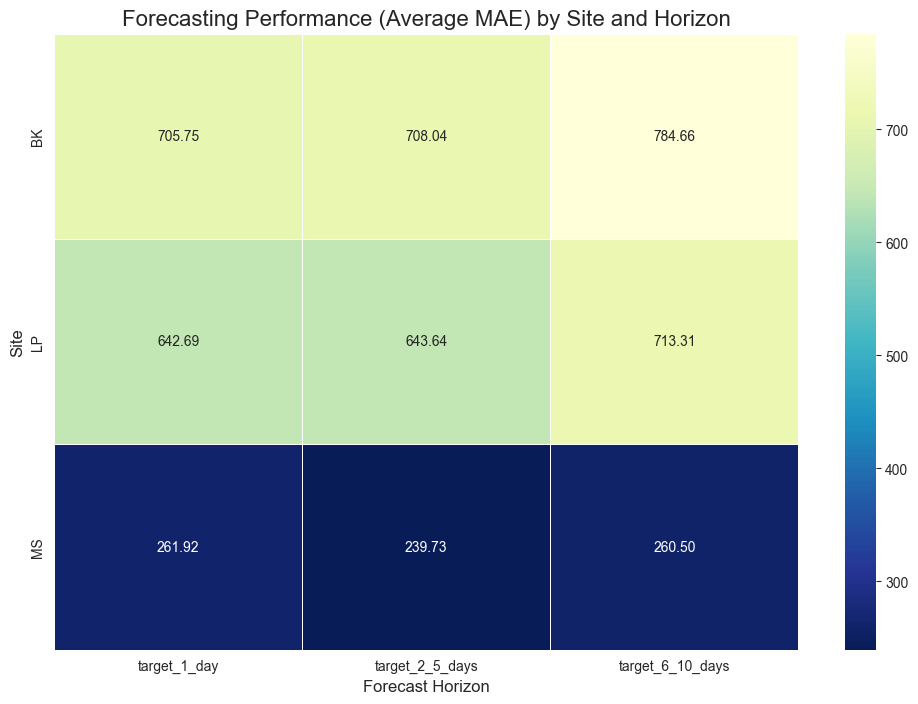


Generating visualization for a sample model...


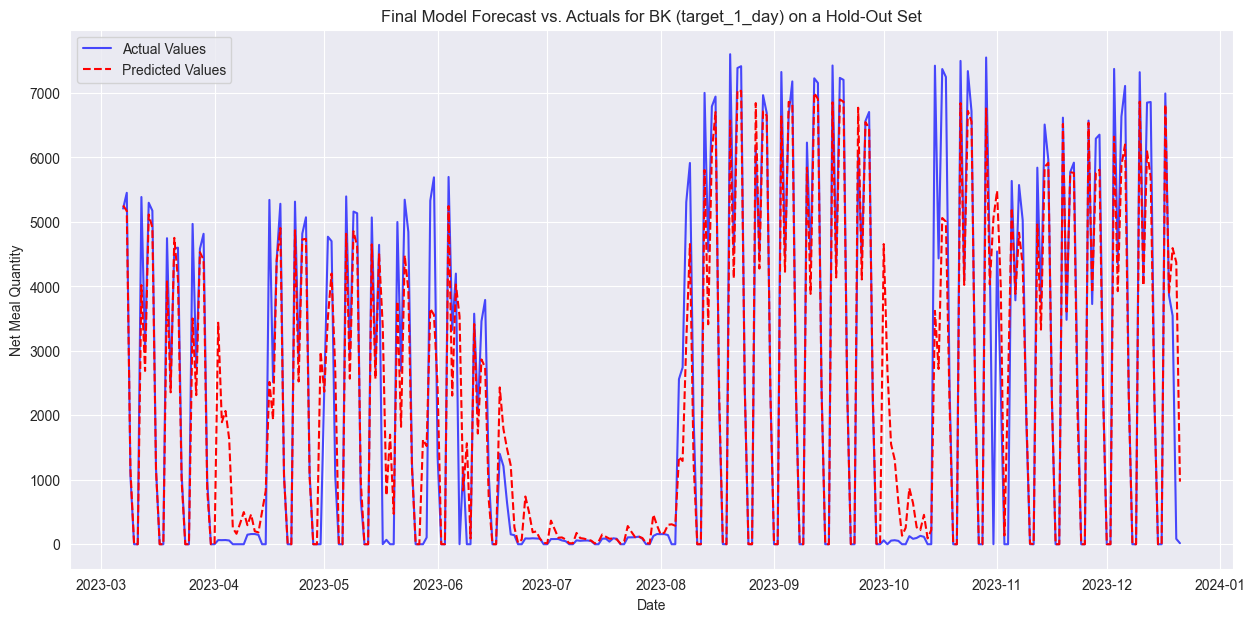


--- End of Step 5 ---


In [199]:
# --- 5. MODEL EVALUATION (CORRECTED) ---
print("\n--- Step 5: Model Evaluation ---")
print("Goal: Review the cross-validated performance metrics.")

results_df = pd.DataFrame(evaluation_results)
print("\nForecasting Model Performance (from Cross-Validation):")
print(results_df.round(2))
print("\nInsight: A heatmap gives a quick overview of which models perform best.")
performance_pivot = results_df.pivot(index='Site', columns='Horizon', values='Average_MAE')

plt.figure(figsize=(12, 8))
sns.heatmap(performance_pivot, annot=True, fmt=".2f", cmap="YlGnBu_r", linewidths=.5)
plt.title('Forecasting Performance (Average MAE) by Site and Horizon', fontsize=16)
plt.ylabel('Site', fontsize=12)
plt.xlabel('Forecast Horizon', fontsize=12)
plt.show()

# Visualize predictions for one example using the FINAL model on a hold-out set
print("\nGenerating visualization for a sample model...")
if not models or not evaluation_results:
    print("No models were trained, skipping visualization.")
else:
    site_to_plot = results_df['Site'].iloc[0]
    horizon_to_plot = 'target_1_day'

    # Re-create the X and y for plotting
    site_features_plot = time_features.copy()
    for lag in [1, 2, 3, 7, 14]:
        site_features_plot[f'site_lag_{lag}'] = pivot_demand[site_to_plot].shift(lag)
    site_features_plot['site_rolling_mean_7'] = pivot_demand[site_to_plot].shift(1).rolling(window=7).mean()
    site_features_plot['site_rolling_mean_14'] = pivot_demand[site_to_plot].shift(1).rolling(window=14).mean()
    site_features_plot = site_features_plot.ffill().bfill().fillna(0)

    y_series_plot = target_dfs[horizon_to_plot][site_to_plot]
    temp_df_plot = pd.concat([site_features_plot, y_series_plot.rename('target')], axis=1)
    temp_df_plot.dropna(subset=['target'], inplace=True)
    X_plot = temp_df_plot.drop('target', axis=1)
    y_plot = temp_df_plot['target']

    plot_split_index = int(len(X_plot) * 0.8)
    X_test_plot = X_plot[plot_split_index:]
    y_test_plot = y_plot[plot_split_index:]

    final_model_to_plot = models[site_to_plot][horizon_to_plot]['model']
    y_pred_plot = final_model_to_plot.predict(X_test_plot)

    plt.figure(figsize=(15, 7))
    plt.plot(y_test_plot.index, y_test_plot, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(y_test_plot.index, y_pred_plot, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Final Model Forecast vs. Actuals for {site_to_plot} ({horizon_to_plot}) on a Hold-Out Set')
    plt.xlabel('Date')
    plt.ylabel('Net Meal Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- End of Step 5 ---")





In [178]:
# show worst predications



--- Step 6: Generating Future Forecasts ---
Predicting future demand...

Insight: Here are the final 14-day forecasts for each site.


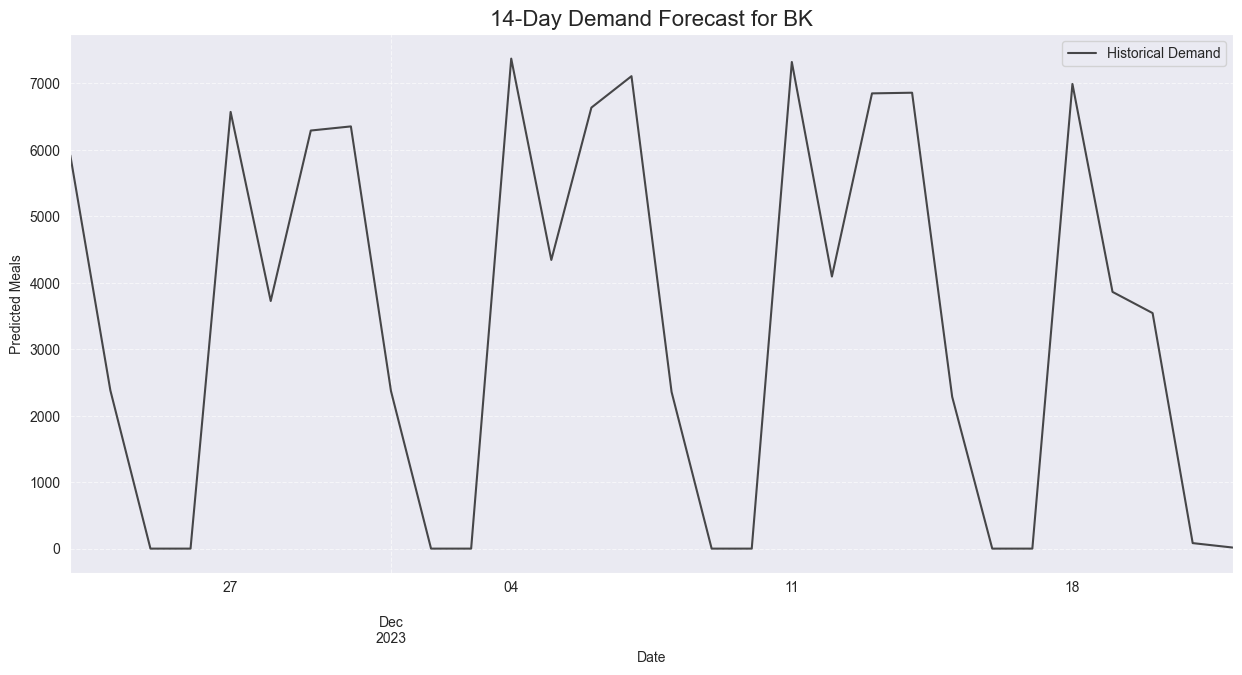

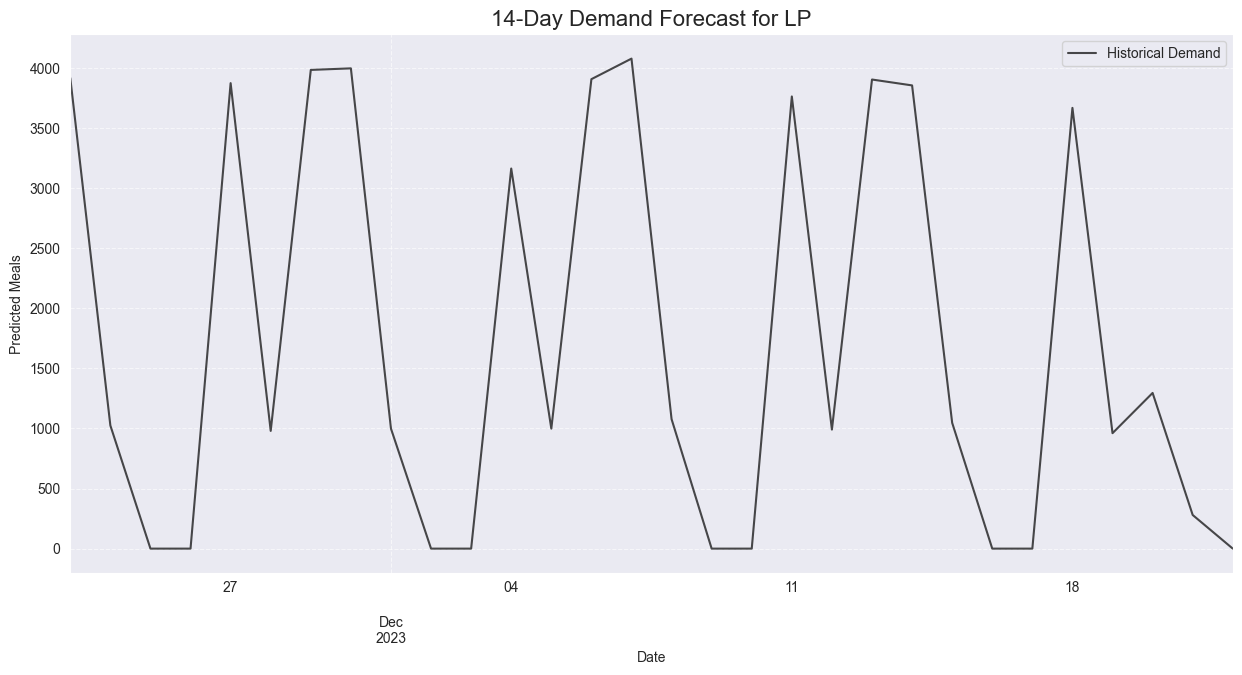

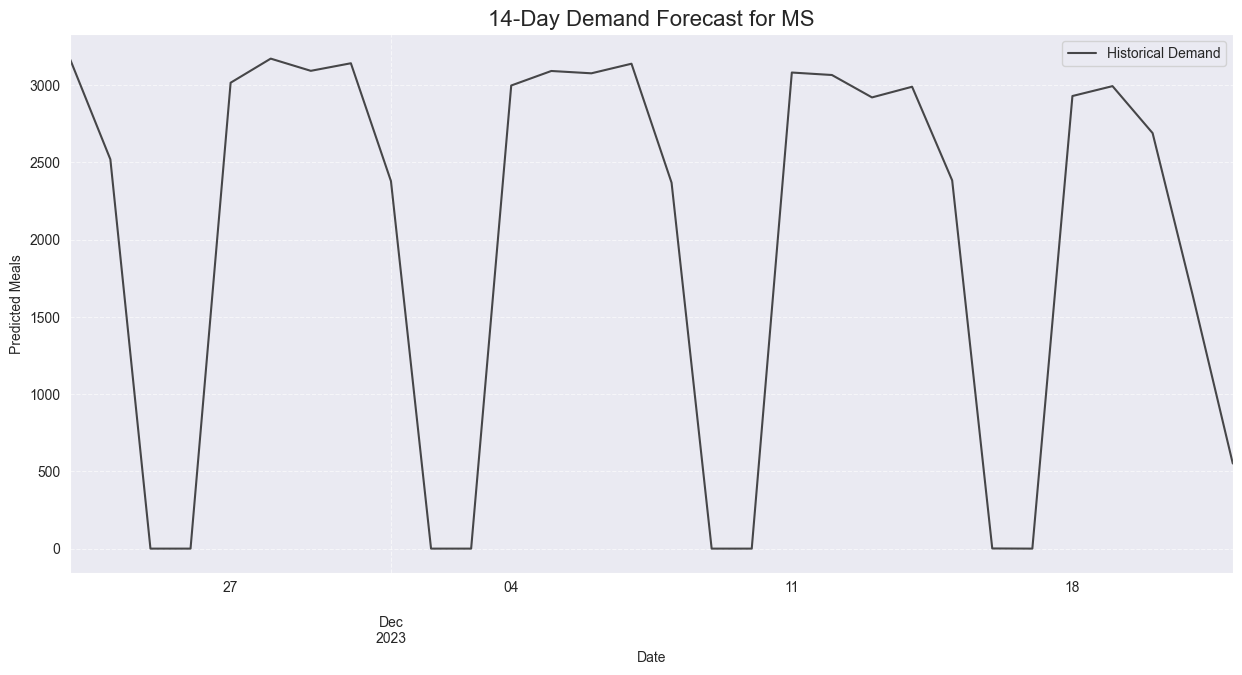


Sample Forecast for the next available day:
   target_1_day target_2_5_days target_6_10_days
BK    678 meals       727 meals        158 meals
LP    264 meals       887 meals        321 meals
MS     65 meals      2400 meals       1771 meals

--- End of Step 6 ---


In [195]:
# --- 6. GENERATING FUTURE FORECASTS (CORRECTED) ---
print("\n--- Step 6: Generating Future Forecasts ---")

last_date = pivot_demand.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')

# Create the base time-based features for the future
future_features_base = pd.DataFrame(index=future_dates)
future_features_base['day_of_year'] = future_features_base.index.dayofyear
future_features_base['weekday'] = future_features_base.index.weekday
future_features_base['is_weekend'] = (future_features_base.index.weekday >= 5).astype(int)
future_features_base['month'] = future_features_base.index.month
future_features_base['quarter'] = future_features_base.index.quarter
future_features_base['day_of_month'] = future_features_base.index.day
future_features_base['sin_doy'] = np.sin(2 * np.pi * future_features_base['day_of_year'] / 365.25)
future_features_base['cos_doy'] = np.cos(2 * np.pi * future_features_base['day_of_year'] / 365.25)
future_features_base['is_holiday'] = future_features_base.index.to_series().apply(lambda x: int(x in de_holidays))

print("Predicting future demand...")
future_predictions = {}

# Combine historical and future index for calculating future features
full_pivot_history = pd.concat([pivot_demand, pd.DataFrame(index=future_dates)])

for site in models:
    future_predictions[site] = {}
    temp_future_features = future_features_base.copy()

    # Get the complete history for this specific site
    full_series = pd.concat([pivot_demand[site], pd.Series(index=temp_future_features.index, dtype='float64')])

    # *** START OF FIX ***
    # Recreate ALL features exactly as they were for training

    # 1. Recreate GENERIC features (mean across all sites)
    # These were the features causing the KeyError
    for lag in [1, 2, 3, 7, 14]:
        temp_future_features[f'lag_{lag}'] = full_pivot_history.shift(lag).mean(axis=1)[temp_future_features.index]

    # These rolling means are based on the generic 'lag_1' feature
    temp_future_features['rolling_mean_7'] = temp_future_features['lag_1'].rolling(window=7).mean()
    temp_future_features['rolling_mean_14'] = temp_future_features['lag_1'].rolling(window=14).mean()

    # 2. Recreate SITE-SPECIFIC features
    for lag in [1, 2, 3, 7, 14]:
        temp_future_features[f'site_lag_{lag}'] = full_series.shift(lag)[temp_future_features.index]
    temp_future_features['site_rolling_mean_7'] = full_series.shift(1).rolling(window=7).mean()[
        temp_future_features.index]
    temp_future_features['site_rolling_mean_14'] = full_series.shift(1).rolling(window=14).mean()[
        temp_future_features.index]
    # *** END OF FIX ***

    temp_future_features = temp_future_features.ffill().bfill().fillna(0)

    for horizon, model_info in models[site].items():
        model = model_info['model']
        # Now the columns in temp_future_features will match reg_features
        X_future = temp_future_features[reg_features]
        predictions = model.predict(X_future)
        future_predictions[site][horizon] = predictions

# Format the forecast for the first day for easy reading
forecast_day_1 = pd.DataFrame({
    site: {
        horizon: f"{int(preds[0])} meals" for horizon, preds in site_preds.items()
    } for site, site_preds in future_predictions.items()
}).T

# --- VISUALIZATION 6.1: FINAL FORECAST PLOTS ---
print("\nInsight: Here are the final 14-day forecasts for each site.")
for site in future_predictions:
    plt.figure(figsize=(15, 7))
    # Plot historical data for context
    pivot_demand[site].tail(30).plot(label='Historical Demand', color='black', alpha=0.7)
    for horizon in future_predictions[site]:
        # Only plot the 1-Day Ahead forecast for clarity, or choose another primary one
        if '1-Day' in horizon:
             plt.plot(future_dates, future_predictions[site][horizon], label=f'Forecast ({horizon})', linestyle='--', marker='o')
    plt.title(f'14-Day Demand Forecast for {site}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Predicted Meals')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
print("\nSample Forecast for the next available day:")
print(forecast_day_1)
print("\n--- End of Step 6 ---")

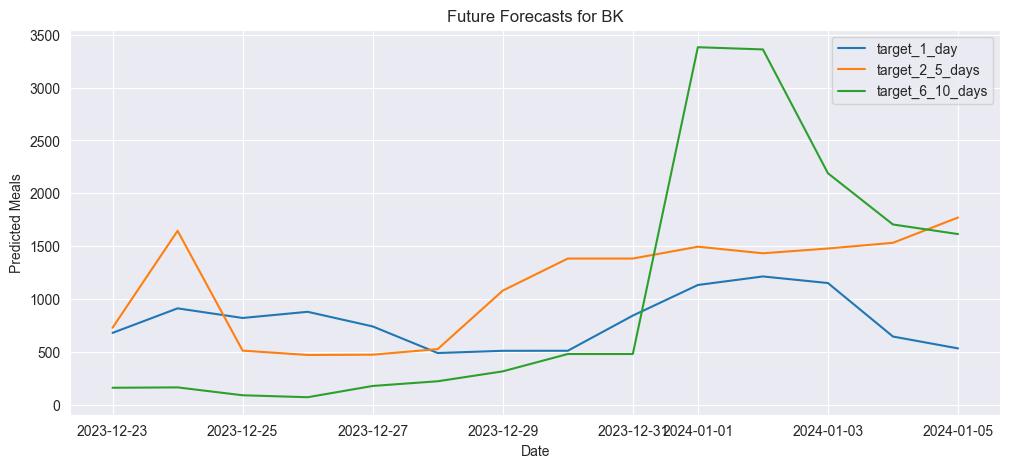

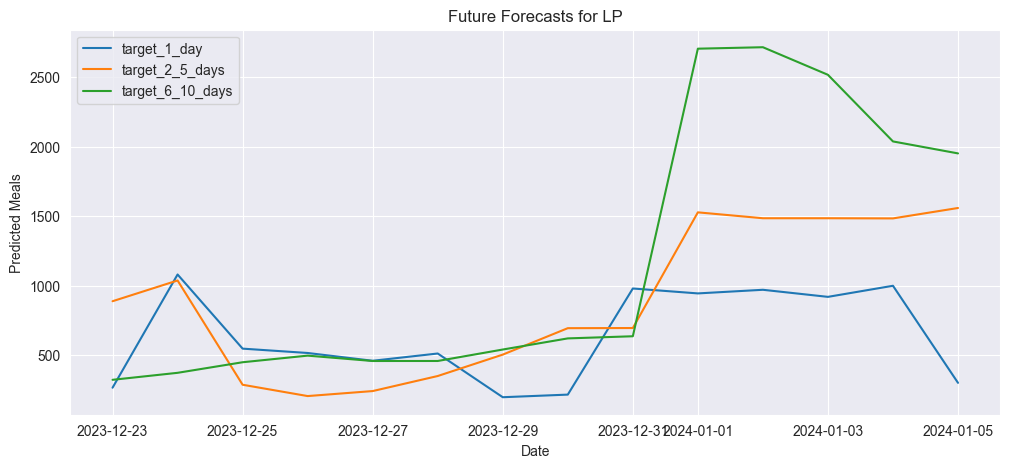

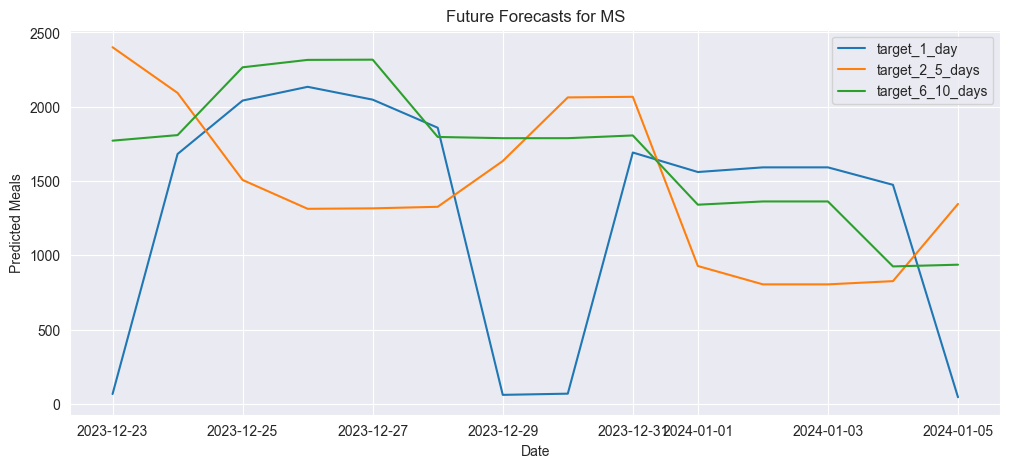

In [188]:
for site in future_predictions:
    plt.figure(figsize=(12, 5))
    for horizon in future_predictions[site]:
        plt.plot(future_dates, future_predictions[site][horizon], label=horizon)
    plt.title(f'Future Forecasts for {site}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Meals')
    plt.legend()
    plt.grid(True)
    plt.show()


In [80]:
column_names = df.columns.tolist()

print(column_names)


['DateOfOrder', 'OrderId', 'TransactionId', 'DateOfService', 'OrderQty', 'MenuName', 'MenuPrice', 'MenuSubsidy', 'BookingNr', 'GroupName', 'CanceledQty', 'DateOfCancel', 'Site', 'SchoolID', 'net_qty', 'days_to_cancel', 'MenuNorm', 'MenuBase', 'MenuCode', 'day_of_year', 'weekday', 'is_weekend', 'sin_doy', 'cos_doy', 'cancel_timing', 'subsidy_pct', 'month', 'quarter', 'day_of_month', 'is_month_end', 'is_month_start', 'order_hour', 'morning', 'afternoon', 'evening', 'hist_cancel_rate', 'is_holiday', 'is_canceled']
